# Sprint5課題 機械学習スクラッチSVM   

**この課題の目的**    
- スクラッチを通してSVMを理解する
- 線形モデルと異なる手法に触れる

**スクラッチによる実装**   
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

SVMは分類と回帰双方に使用できますが、分類のみを扱います。SVMで重要な要素としてカーネルがありますが、まずは線形カーネルを作成します。他のカーネルの作成はアドバンス課題とします。また、SVMにはハードマージン、ソフトマージンという考え方がありますが、より単純なハードマージンを扱います。

<img src='svmclassification.png' width='400'>

今回は上の表の左側の条件に当てはまるものを実装していただきます。

## 【問題1】 SVM分類機のクラスを作成する

SVM分類器のクラスを作成し、Sprint0で作成した分類のパイプラインに組み込んでください。

クラスの基本構造はSprint3の線形回帰を参考にし、名前は<font color='red'>ScratchSVMClassifier</font>としてください。

メソッドやパラメータなどはscikit-learnを参考にしてください。

[sklearn.svm.SVC — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

scikit-learnにおけるパラメータについて

scikit-learnの実装はソフトマージンSVMになっています。ハードマージンSVMを再現するには、パラメータCを<font color='red'>C=1e10</font>のように非常に大きな値を設定します。（無限大に向けてCを大きくするほどハードマージンSVMに近づきます）

また、線形カーネルをscikit-learnで使う場合は<font color='red'>kernel="linear"</font>と指定します。デフォルトでは<font color='red'>kernel="rbf"</font>になっており、多項式カーネルと呼ばれるものになっています。

### ・ラグランジュの未定乗数法による最急降下   

SVMの最適化問題は、ラグランジュの未定乗数法により解くことができます。サンプル数分のラグランジュ乗数 $\lambda$ を用意して、以下の式により更新していきます。
 
$$ \lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)}) $$

ここで $k(x_i,x_j)$ はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分はメソッド化しておきましょう。

$$ k(x_i, x_j) = x_{i}^{T} x_j $$

条件として、更新毎に $\lambda_i >= 0$ を満たす必要があります。満たさない場合は $ \lambda_i = 0$ とします。

$ \lambda^{new}_{i} $ : 更新後のi番目のサンプルのラグランジュ乗数

$ \lambda_i $ : 更新前のi番目のサンプルのラグランジュ乗数

$ \alpha $ : 学習率

$ \lambda_j $ : j番目のサンプルのラグランジュ乗数

$ y_i $ : i番目のサンプルのラベル

$ y_j $ : j番目のサンプルのラベル

$ x_i $ : i番目のサンプルの特徴量ベクトル

$ x_j $ : j番目のサンプルの特徴量ベクトル

あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
def kernel_func(Xi, Xj):
    '''
    カーネル計算を行う関数
    Parameters
    --------------
    Xi : 次の形のndarray, shape (n_samples, n_features)
        検証用データの特徴量
    Xj : 次の形のndarray, shape (n_samples, n_features)
        検証用データの特徴量
        
    Returns
    ----------
    カーネルの計算結果
    ''' 
    return np.dot(Xi, Xj.T)

適当に値を決めて計算する

In [3]:
#ラグランジュ乗数
lam = np.array([1, 1, 1, 1], dtype=np.float)[:, np.newaxis]

#学習率
eta = 0.5

#サンプルのラベル
y = np.array([-1, -1, 1, 1])[:, np.newaxis]

#特徴量
x = np.array([[1, 3, 3],
                        [1, 3, 2],
                        [1, 5, 4],
                        [1, 4, 6]], dtype=np.float)

In [4]:
def _gradient_descent(X, y):
    '''
    ラグランジュ未定乗数法による最急降下法でパラメータを更新する関数

    Parameter
    --------------
    X : 次の形のndarray, shape (n_samples, n_features)
        学習用データ
    y : 次の形のndarray, shape (n_samples, 1)
        学習用データの正解ラベル
        
    Returns
    -----------
    lam : 次の形のndarray, shape (n_samples, 1)
        更新されたラグランジュ乗数
    '''
    #ラグランジュの未定乗数法による再急降下
    for i in range(len(y)):
        
        ans = 0  #初期化
        for j in range(len(y)):
                
            #1つのインデックスに対してすべてのインデックスをかけ、合計する
            ans += lam[j] * y[i] * y[j] * kernel_func(X[i, :], X[j, :])

        #ラグランジュ乗数を更新
        lam[i] += eta * (1 - ans)

        #ラグランジュ乗数が0未満の時、0を代入
        if  lam[i] < 0:
            lam[i] = 0
        
    return lam

In [5]:
kernel_func(x, x)

array([[19., 16., 28., 31.],
       [16., 14., 24., 25.],
       [28., 24., 42., 45.],
       [31., 25., 45., 53.]])

### ・サポートベクターの決定   
計算したラグランジュ乗数 $\lambda$
 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。

閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。

In [6]:
#しきい値
threshold=1e-5

In [7]:
#ラグランジュ乗数の初期化
lam = np.ones(x.shape[0])[:, np.newaxis]
        
#イテレーションの回数実行(10回)
for i in range(10):
    lam = _gradient_descent(x, y)
        
#しきい値以上のサポートベクターを取り出す
sv = np.where(lam > threshold)[0]
sv

array([0, 2])

### ・推定   
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた $y(x)$ の符号が分類結果です。

$$ y(x) = \sum_{n=1}^{N}\lambda_n y_n k(x, s_n) $$

$ x $ : 推定したいデータの特徴量ベクトル

$ N $ : サポートベクターの数

$ n $ : サポートベクターのインデックス

$ \lambda_n $ : $ n $番目のサポートベクターのラグランジュ乗数

$ y_n $ : $ n $番目のサポートベクターのラベル

$ k() $ : カーネル関数

$ s_n $ : $ n $番目のサポートベクターの特徴量

### ・これまでのまとめ   

SVMによるマージン最大化問題が以下の式の双対表現に帰着できることは、上記の説明と講義で理解されたかと思います。

$ \mathrm{argmin}_{w,b}\frac{1}{2}||w||^2 $

この制約付き最小化問題を解くために、ラグランジュ乗数λを導入し、wとbの制約条件を用いて、$ \theta $と$\theta_0 $を消去すれば

$ L(\lambda) = \sum_{i=1}^{n} \lambda_i -\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_{i}\lambda_{j}y_{i}y_{j}x_i^Tx_j $

という関数が得られ、この関数を$ \lambda $に対して最大化すれば良いのでした。この$ \lambda $の最適解を求める方法はみなさんがこれまでに学習してきた勾配降下法を用いれば良いわけです。$ \lambda $がわかれば$ \theta $と$\theta_0 $が求まるので、分類境界線が求まります。

以下の図は、SVMを実装するフローを示したものです。実装の際に参考にしてください

<img src='svmflow.png' width='600'>

In [30]:
import numpy as np

class ScratchSVMClassifier:
    '''
    SVMのスクラッチ実装

    Parameters
    ----------
    num_iter : int
        イテレーション数
    eta : float
        学習率(0 < eta <= 1の範囲)
    threshold : float
        しきい値
    bias : bool
        バイアス項を入れない場合はFalse
    kernel : object
        カーネルの式, 多項式の場合は'poly'
    gamma : float
        'poly'のカーネル係数
    degree : int
        'poly'のカーネル係数
    coef0 : float
        'poly'の独立項

    Attributes
    ----------
    self.lam_ : 次の形のndarray, shape (n_features,)
        ラグランジュ乗数
    self.y_label : list
        ラベルのユニーク値
    self.sv_X : 次の形のndarray, shape (n_samples, n_features)
        サポートベクターの特徴量
    self.sv_lam : 次の形のndarray, shape (n_samples, 1)
        サポートベクターのラグランジュ乗数
    self.sv_y : 次の形のndarray, shape (n_samples, 1)
        サポートベクターのラベル
    self.theta : 次の形のndarray, shape (n_samples, n_features)
        分類境界の勾配
        
    '''
    def __init__(self, num_iter=50, eta=0.05, threshold=1e-5, 
                             bias=True, kernel='linear', gamma=5, degree=5, coef0=0):
        # ハイパーパラメータを属性として記録
        self.iter              = num_iter     #イテレーション数
        self.eta              = eta               #学習率
        self.threshold   = threshold     # しきい値
        self.bias             = bias             #バイアス項(True : あり, False : なし)
        self.kernel         = kernel          #カーネルの式(linear :  線形カーネル, poly : 多項式カーネル)
        self.gamma       = gamma       #カーネル係数
        self.degree       = degree        #カーネル係数
        self.coef0         = coef0          #'poly'の独立項

        #　インスタンス変数
        self.lam        = None      #ラグランジュ乗数
        self.y_label  = None      #ラベルのユニーク値
        self.sv_X      = None      #サポートベクターの特徴量
        self.sv_lam  = None      #サポートベクターのラグランジュ乗数
        self.sv_y      = None      #サポートベクターのラベル
        self.theta     = None     #分類境界の勾配
        

    def fit(self, X, y):
        '''
        SVMで学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        '''
        #yのラベルのユニーク値をリストに保管
        self.y_label = []
        self.y_label.append(np.unique(y)[0])
        self.y_label.append(np.unique(y)[1])
        
        #yをコピーし、-1, 1に変換
        y_copy = y.copy()
        y_copy[y_copy == np.unique(y_copy)[0]] = -1
        y_copy[y_copy == np.unique(y_copy)[1]] = 1
        
        #ラグランジュ乗数の初期化
        self.lam = np.ones(X.shape[0])[:, np.newaxis]
        
        #イテレーションの回数実行
        for i in range(self.iter):
            self.lam = self._gradient_descent(X, y_copy)
        
        #しきい値以上のサポートベクターを取り出す
        sv = np.where(self.lam > self.threshold)[0]
            
        #サポートベクターの数を取得
        sv_nam = len(sv)

        #サポートベクターのデータを格納
        self.sv_X = X[sv, :] #特徴量ベクトル
        self.sv_lam = self.lam[sv] #ラグランジュ乗数
        self.sv_y = y_copy[sv] #ラベル

        #thetaの計算
        self.theta = np.zeros(X.shape[1]) #Xの特徴量の数の0配列を用意
        for n in range(sv_nam):
            self.theta += self.sv_lam[n] * self.sv_y[n] * self.sv_X[n] #サポートベクターの数だけ足す

        #theta0の計算
        self.theta0 = np.sum(self.sv_y) #サポートベクターのラベル名の合計
        self.theta0 -= np.sum(np.dot(self.theta, self.sv_X.T)) #thetaとサポートベクターの特徴量の合計を引く
        self.theta0 /= sv_nam  #サポートベクターの数で割る


    def predict(self, X):
        '''
        SVMを使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量

        Returns
        -------
        y_pred : 次の形のndarray, shape (1, n_samples)
            予測したラベル
        '''        
        #線形カーネルの時
        if self.kernel == 'linear':
            y_pred = (np.sum((self.sv_lam.T * self.sv_y) 
                               * self._kernel_func(X, self.sv_X), axis=1))
        
        #多項式カーネルの時
        elif self.kernel == 'poly':
            y_pred = (np.sum((self.sv_lam.T * self.sv_y) 
                              * self._poly_kernel_func(X, self.sv_X), axis=1))

        #バイアス項がないとき
        if self.bias == False:
            y_pred = np.dot(self.theta, X.T)
        
        #予測結果が0未満なら-1側, 0より大きいなら1側のラベルを割り振る
        for i in range(X.shape[0]):
            if y_pred[i] < 0:
                y_pred[i] = self.y_label[0]
            else:
                y_pred[i] = self.y_label[1]

        return y_pred
    
    
    def _kernel_func(self, Xi, Xj):
        '''
        線形カーネル計算を行う関数
        Parameters
        --------------
        Xi : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        Xj : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
            
        Returns
        ----------
        線形カーネルの計算結果
        ''' 
        return np.dot(Xi, Xj.T)
    

    def _poly_kernel_func(self, Xi, Xj):
        '''
        多項式カーネル計算を行う関数
        Parameters
        --------------
        Xi : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        Xj : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        
        Returns
        ----------
        多項式カーネルの計算結果
        ''' 
        return self.gamma * (np.dot(Xi, Xj.T) + self.coef0)**self.degree
            
    
    def _gradient_descent(self, X, y):
        '''
        最急降下法でパラメータを更新する関数

        Parameter
        --------------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, 1)
            学習用データの正解ラベル

        Returns
        -----------
        lam : 次の形のndarray, shape (n_samples, 1)
            更新されたパラメータ   
        '''
        #カーネル関数の計算
        #線形
        if self.kernel == 'linear':
            k = self._kernel_func(X, X)
        #多項式
        elif self.kernel == 'poly':
            k = self._poly_kernel_func(X, X)
                
        #サンプル数の一時変数
        samples = len(y)

        #ラグランジュ乗数の未定乗数法による再急降下
        for i in range(samples):
            ans = 0  #初期化
            for j in range(samples):
                #1つのインデックスに対してすべてのインデックスをかけ、合計する
                ans += self.lam[j] * y[i] * y[j] * k[i, j]

            #ラグランジュ乗数を更新
            self.lam[i] += self.eta * (1 - ans)
            
            #ラグランジュ乗数が0未満の時、0を代入
            if  self.lam[i] < 0:
                self.lam[i] = 0

        return self.lam

シンプルデータセット1で線形カーネル, irisデータで多項式カーネルを検証する

In [9]:
#シンプルデータセット1の読み込み
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), 
                                        np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

#データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [10]:
#irisデータセットの読み込み
iris = datasets.load_iris()

#説明変数をX_dfに、目的変数をy_dfに格納し、列目を付ける
X_df = pd.DataFrame(iris.data, columns=iris.feature_names)
y_df = pd.DataFrame(iris.target, columns=['Species'])

#結合
df = pd.concat([X_df, y_df], axis=1)

#抜き出し
df = df[(df['Species'] == 1) | (df['Species'] == 2)][['petal length (cm)', 'petal width (cm)', 'Species']]

#説明変数をX、目的変数をyというndarrayに格納
X_iris = df.iloc[:, :-1].values
y_iris = df.iloc[:, -1].values

#データを分割
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.25)

#学習用データをfit(平均と標準偏差を計算)し、transform(標準化)
sc = StandardScaler()
X_train_iris_std = sc.fit_transform(X_train_iris)

#検証用データをtransform(標準化)
X_test_iris_std = sc.transform(X_test_iris)

**シンプルデータセット1で線形カーネルの検証**   
スクラッチしたクラス

In [11]:
#学習
s_svm = ScratchSVMClassifier()
s_svm.fit(X_train, y_train)

In [12]:
#予測
s_y_pred = s_svm.predict(X_test)
s_y_pred

array([-1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
        1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
        1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,
        1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
       -1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,
        1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1., -1., -1.,  1.,  1.,  1.,  1., -1.])

scikit learn

In [13]:
svm = SVC(kernel='linear')

#学習
svm.fit(X_train, y_train)

#予測
y_pred = svm.predict(X_test)
y_pred

array([-1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1,
        1, -1, -1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,
       -1,  1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1, -1, -1, -1,
        1,  1,  1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1, -1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1,
       -1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1,
        1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1, -1])

**irisデータで多項式カーネルの検証**  
スクラッチしたクラス

In [14]:
#学習
s_svm_poly = ScratchSVMClassifier(num_iter=300, eta=0.01, kernel='poly', gamma=3, degree=3, coef0=1)
s_svm_poly.fit(X_train_iris_std, y_train_iris)

In [15]:
#予測
s_y_pred_poly = s_svm_poly.predict(X_test_iris_std)
s_y_pred_poly

array([1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 1., 2., 2., 2., 1., 2., 1.,
       1., 1., 1., 2., 2., 2., 2., 1.])

scikit learn

In [16]:
#学習
svm_poly = SVC(kernel='poly', gamma=3, degree=3, coef0=1)
svm_poly.fit(X_train_iris_std, y_train_iris)

#予測
y_pred_poly = svm_poly.predict(X_test_iris_std)
y_pred_poly

array([1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2,
       2, 2, 1])

## 【問題2】 多項式カーネルの作成

問題1では線形カーネルを使用しましたが、多項式カーネルにも切り替えられるようにしましょう。

「線形カーネルの式」

$$ k(x_i, x_j) = x_{i}^{T} x_j $$

「多項式カーネルの式」

$$ k(x_i, x_j) = \gamma(x_{i}^{T} x_j + \theta_0)^{d} $$

$ \gamma $, $\theta_0 $, $ d $はハイパーパラメータです。

線形カーネルは$ \gamma = 1 $, $ \theta_0 = 0 $, $ d = 1 $の場合の多項式カーネルと等しいと言えます

## 【問題3】 指標値の算出

分類に関する指標値で精度を確認してください。

In [17]:
def evalution(y_test, y_pred):
    '''
     分類問題の指標値を出力する関数
 
     Paraeters
     -------------
    y_test : 次の形のndarray, shape (n_samples, )
        正解値
    y_pred : 次の形のndarray, shape (n_samples, )
        予測したラベル
    '''
    #accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy :', accuracy)

    #precision
    precision = precision_score(y_test, y_pred)
    print('precision :', precision)

    #recall
    recall = recall_score(y_test, y_pred)
    print('recall :', recall)

    #f1
    f1 = f1_score(y_test, y_pred)
    print('f1 :', f1)

**シンプルデータセット1で線形カーネルの検証**   
スクラッチしたクラス

In [18]:
evalution(y_test, s_y_pred)

accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0


scikit learn

In [19]:
evalution(y_test, y_pred)

accuracy : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0


線形カーネルでのスコアは、スクラッチクラス、sklearともにすべて1.0であり、正確に分類できていた。

**irisデータで多項式カーネルの検証**  
スクラッチしたクラス

In [20]:
evalution(y_test_iris, s_y_pred_poly)

accuracy : 0.92
precision : 0.9230769230769231
recall : 0.9230769230769231
f1 : 0.9230769230769231


scikit learn

In [21]:
evalution(y_test_iris, y_pred_poly)

accuracy : 0.92
precision : 0.9230769230769231
recall : 0.9230769230769231
f1 : 0.9230769230769231


多項式カーネルの精度は、sklearnのモデルと同じであった。

## 【問題4】 決定領域の可視化

値分類のデータセットに対して決定領域を可視化してください。

これまで使用してきた関数に、サポートベクターを色を変えて表示する機能を加えてください。

特にSprint0で作成したシンプルデータセット1に対して以下のように分類ができるかを検証してください。

![](decisionregion.png)

In [22]:
def decision_region(X_train, y_train, model, sv_X=None, sv_y=None, 
                                    step=0.01, title='decision region', 
                                    xlabel='f0', ylabel='f1', 
                                    target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples, 2)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step),
                                                                    np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    if sv_X is not None and sv_y is not None:
        for i, target in enumerate(set(sv_y)):
            plt.scatter(sv_X[sv_y==target][:, 0], sv_X[sv_y==target][:, 1], s=80, color='yellow' , marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

**シンプルデータセット1で線形カーネルの検証**   
スクラッチしたクラス

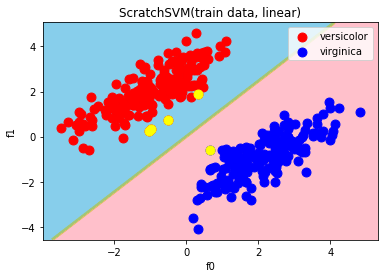

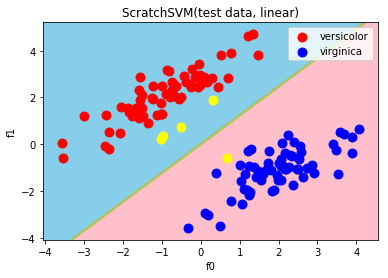

In [23]:
#可視化
#学習用データ
decision_region(X_train, y_train, s_svm, s_svm.sv_X, s_svm.sv_y,
                            title='ScratchSVM(train data, linear)')

#検証用データ
decision_region(X_test, y_test, s_svm, 
                s_svm.sv_X, s_svm.sv_y, title='ScratchSVM(test data, linear)')

scikit learn

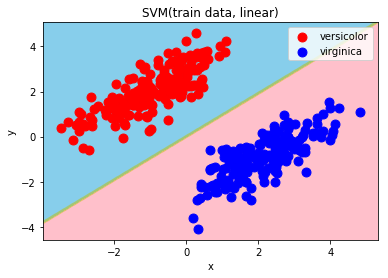

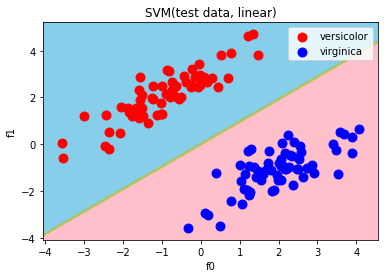

In [24]:
#可視化
#学習用データ
decision_region(X_train, y_train, svm, 
                            title='SVM(train data, linear)', xlabel='x', ylabel='y')

#検証用データ
decision_region(X_test, y_test, svm, title='SVM(test data, linear)')

シンプルデータセット1の分布を可視化すると、いくつかサポートベクターが選ばれており、目視だと最も近いサポートベクター同士のマージンが最大であったので、しっかり学習できていると言える。決定境界もほぼ同様のものとなっていた。

**irisデータで多項式カーネルの検証**  
スクラッチしたクラス

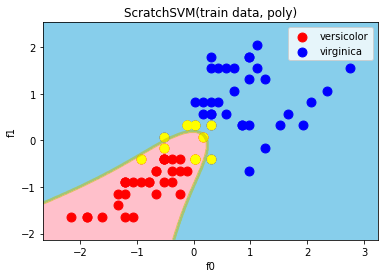

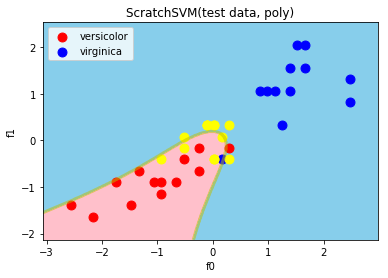

In [25]:
#可視化
#学習用データ
decision_region(X_train_iris_std, y_train_iris, s_svm_poly, 
                        s_svm_poly.sv_X, s_svm_poly.sv_y, title='ScratchSVM(train data, poly)')

#検証用データ
decision_region(X_test_iris_std, y_test_iris, s_svm_poly,  
                            s_svm_poly.sv_X, s_svm_poly.sv_y, title='ScratchSVM(test data, poly)')

scikit learn

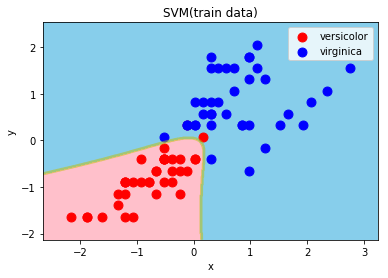

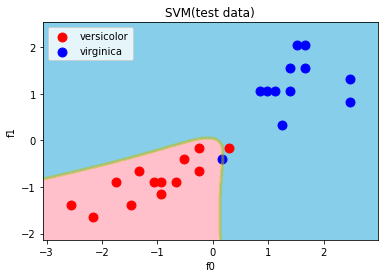

In [26]:
#可視化
#学習用データ
decision_region(X_train_iris_std, y_train_iris, svm_poly, 
                            title='SVM(train data)', xlabel='x', ylabel='y')

#検証用データ
decision_region(X_test_iris_std, y_test_iris, svm_poly, title='SVM(test data)')

多項式カーネルでは、sklearnの決定境界とは若干異なっていたが、分類自体はそれなりにできていた。スクラッチしたクラスでは、イテレーション回数を増やすと上手く分類できなかったことがあり、カーネル係数であるgammaとdegreeを変えると分類できるようになった。そのため、グリッドサーチなどでパラメータを上手く調節することが大事だと感じた。

## 【問題5】 時間の計測

SVMの学習には時間がかかるため、効率的な実装が望まれます。事前学習期間に行なったように、時間を計測して改善していきましょう。特に$ \lambda $
の更新部分は繰り返し処理が多いため、効率的なコードを目指してください。

イテレーション50回で学習

In [31]:
import time
t0 = time.time()

#学習
s_svm = ScratchSVMClassifier()
s_svm.fit(X_train, y_train)

t1 = time.time()
print('time : {}s'.format(t1-t0))

time : 44.8110568523407s


イテレーション回数50回のとき、学習に要する時間は約50秒であった。ラグランジュ関数を使用している部分で、rangeの中をlen(y)としていたので、その部分を一時変数を取得して行うと約45秒となり、若干だが時間が短縮した。

[Pythonを速くしたいときにやったこと](https://qiita.com/shaka/items/f180ae4dc945dc7b9066)

## 【問題6】 ロジスティック回帰とSVM

最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

- ロジスティック回帰とSVMは本質的に何が異なっているか

注意点
答えがある問いではありません。いろいろな視点から見て理解を深めていきましょう。

- ロジスティック回帰  
仮説にシグモイド関数使用する。予測に確率を使用し、しきい値より大きいなら1、小さいなら0とすることで分類。

- SVM  
マージンが最大となるような決定境界、つまり重みが最小となるような決定境界を引くことを目指す。クラスラベルyが-1, 1とすると、決定境界が0より大きければy=1、決定境界が0より小さければy=-1となるような勾配、切片を求める。